<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S6/assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [136]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The overrides

Override Batchnorm to create ghostbatchnorm

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1
        self.ghostbatchnorm = False
        self.num_splits = 1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 28x28x1 | Out: 26x26x8 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(12),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 26x26x8 | Out: 24x24x10 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x10 | Out: 22x22x12 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | Out: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 11x11x12 | Out: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 9x9x16 | Out: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
        ) # In: 7x7x16 | Out: 5x5x16 | RF: 20

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 5x5x16 | Out: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x16 | Out: 1x1x10 | RF: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def set_ghostbatchnorm(self, is_ghostbatchnorm = False, splits = 1):
        self.ghostbatchnorm = is_ghostbatchnorm
        self.num_splits = splits

    def batchnorm(self, num_features):
        if self.ghostbatchnorm and self.ghostbatchnorm == True:
            return GhostBatchNorm(num_features, self.num_splits)
        else:
            return BatchNorm(num_features)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [166]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         BatchNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,728
         BatchNorm-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
        BatchNorm-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch, L1 = 0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if L1 > 0:
      l1_crit = nn.L1Loss(size_average = False).to(device)
      l1_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        l1_loss += l1_crit(param, zero_vector)
      factor = 0.0005
      loss += factor * l1_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified, cal_misclassified = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if cal_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i]:
                        misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, misclassified

In [0]:
from torch.optim.lr_scheduler import StepLR

matrix_data = {}

EPOCHS = 1

def run_model(heading, data_key, is_GBN, l1_decay, l2_decay, cal_misclassified = False):
    print(heading)
    net_model = Net()
    if is_GBN == True:
        net_model.set_ghostbatchnorm(True, 8)
    else:
        net_model.set_ghostbatchnorm(False)
    model =  net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = l2_decay)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    test_losses = []
    test_acc = []
    misclassified = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, train_loader, optimizer, epoch, L1 = l1_decay)
        # scheduler.step()
        test_losses, test_acc, misclassified = test(model, device, test_loader, test_losses, test_acc, misclassified, cal_misclassified = cal_misclassified)
    matrix_data[data_key] = {"loss":test_losses, "accuracy":test_acc, "misclassified":misclassified}

run_model("**** Without L1/L2 with BN ****", "BN", False, 0, 0)
#run_model("**** Without L1/L2 with GBN ****", "GBN", True, 0, 0)
#run_model("**** With L1 with BN ****", "L1BN", False, 0.0004, 0)
#run_model("**** With L1 with GBN ****", "L1GBN", True, 0.0004, 0)
#run_model("**** With L2 with BN ****", "L2BN", False, 0, 0.0004)
#run_model("**** With L2 with GBN ****", "L2GBN", True, 0, 0.0004)
#run_model("**** With L1L2 with BN ****", "L1L2BN", False, 0.0004, 0.0004, cal_misclassified = True)
#run_model("**** With L1L2 with GBN ****", "L1L2GBN", True, 0.0004, 0.0004, cal_misclassified = True)

# Let's plot losses and accuracy



In [0]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

def plot_matrix(matrix_data, matrix):
    fig = plt.figure(figsize=(10, 10))
    
    plt.title(f'Validation %s' % (matrix))
    plt.xlabel('Epoch')
    plt.ylabel(matrix)

    plt_tuple = ()
    legend_tuple = ()
    for key in matrix_data:
        if matrix.lower() in matrix_data[key]:
            plt_tuple = plt_tuple + (plt.plot(matrix_data[key][matrix.lower()])[0], )
            legend_tuple = legend_tuple + (key, )
    
    plt.legend(plt_tuple, legend_tuple)

    fig.savefig(f'val_%s_change.png' % (matrix.lower()))

### Plot Loss

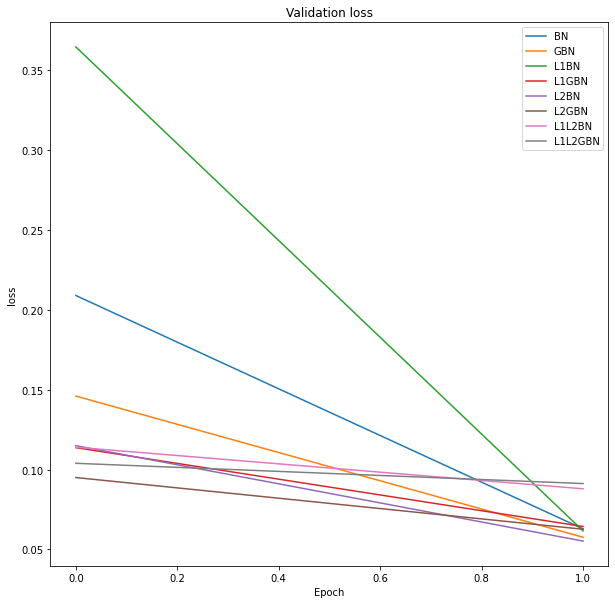

In [188]:
plot_matrix(matrix_data, "loss")

### Plot Accuracy

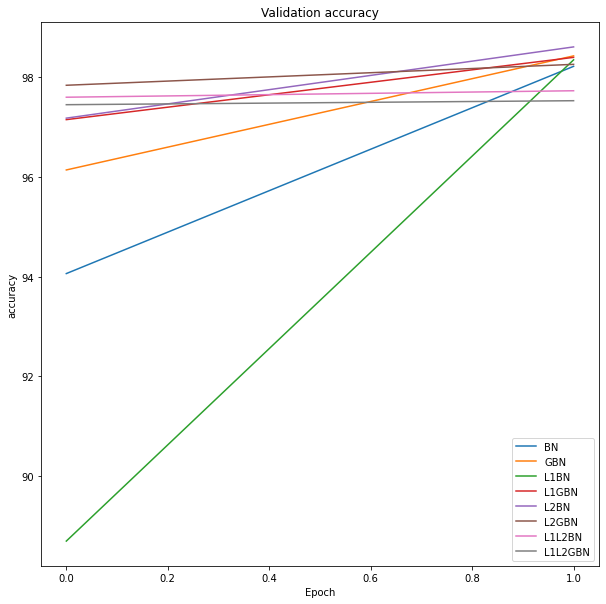

In [189]:
plot_matrix(matrix_data, "accuracy")